A brief preface: some sections in this notebook are written in Ukrainian. Please use a machine translator if needed.

A large number of companies generally place a moratorium on multiple hypothesis tests because, with them, the probability of accidentally finding significance where none exists increases. More simply, the False Positive Rate will increase.

# Dependencies

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

from scipy import stats
import statsmodels.stats.api as sms
from scipy.stats import ttest_ind
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
from scipy.stats import johnsonsb

# The Problem with Multiple A/B Testing

In [ ]:
attempts = 1000
experiment_result = []

for _ in tqdm(range(attempts)):
  cards = np.random.binomial(1, 0.5, 10)
  gussed_cards = np.random.binomial(1, 0.5, 10)
  experiment_result.append((cards==gussed_cards).sum() >= 9)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
successful_result = np.round(np.mean(experiment_result), 4)

print("{} % of 1000 people guessed 9 or more out of 10 cards, averaging {} out of {}.".format(successful_result*100, successful_result*attempts, attempts))

1.4000000000000001 % of 1000 people guessed 9 or more out of 10 cards, averaging 14.0 out of 1000.


In [ ]:
# (1-alpha)^m

def experiment():
  cards = np.random.binomial(1,0.5,size=10)
  guess = np.random.binomial(1,0.5,size=10)
  return (cards == guess).sum() >= 9

cumulative_experiment_result = []
for number_of_people in tqdm(range(10, 500, 40)):
  prob = np.mean([any([experiment() for _ in range(number_of_people)]) for _ in range(1000)])
  cumulative_experiment_result.append(prob)

  0%|          | 0/13 [00:00<?, ?it/s]

In [ ]:
formula_values = [1-(1-0.01)**m for m in range(10, 500, 40)]

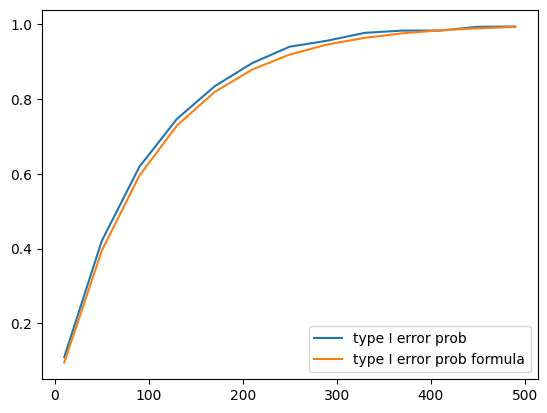

In [ ]:
plt.plot(range(10, 500, 40), cumulative_experiment_result, label='type I error prob')
plt.plot(range(10, 500, 40), formula_values, label='type I error prob formula')

plt.title('')
plt.legend()
plt.show()

# Multiple A/B Test Simulation

In [ ]:
mul_result = []
for _ in tqdm(range(1000)):
  control = np.random.normal(10, 2, 1000)
  inner_test = []

  # alternative 3 hypotheses from one distribution
  for _ in range(3):
    test = np.random.normal(10, 2, 1000)
    _, pval = ttest_ind(control, test, equal_var=False)
    inner_test.append(pval<0.05)

  mul_result.append(any(inner_test))

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
print("Type I error in multiple A/B testing through simulation:", np.mean(mul_result))
formula_res = 1 - (1 - 0.05) ** 3
print("Type I error in multiple A/B testing through formula:", np.round(formula_res,2))

Type I error in multiple A/B testing through simulation: 0.127
Type I error in multiple A/B testing through formula: 0.14


In [ ]:
# make code more scalability
def stat_test():
  control = np.random.binomial(1, 0.5, 1000)
  test = np.random.binomial(1, 0.5, 1000)
  _, pval = proportions_ztest([control.sum(), test.sum()], [len(control), len(test)], alternative='two-sided')
  return pval

def multi_ab_simulation(total_simulation: int, hypothesis_num: int, alpha=0.05):
  return np.mean([any([stat_test() < alpha for _ in range(hypothesis_num)]) for _ in tqdm(range(total_simulation))])

In [ ]:
# try with 10 hypotheses
mul_result = multi_ab_simulation(1000, 10)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
print(np.mean((mul_result)))
print(1 - (1 - 0.05) ** 10)

0.422
0.4012630607616213


## Addressing the Multiple A/B Testing Problem
Methods to reduce type I error: Bonferroni correction, Holm method, Benjamini-Hochberg procedure.

### Bonferroni Correction

In [ ]:
# new alpha = default alpha / number of hypothesis
new_alpha = 0.05 / 10

In [ ]:
corr_result = multi_ab_simulation(1000, 10, new_alpha)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
print(np.mean((corr_result)))
print(1 - (1 - new_alpha) ** 10)

0.05
0.048889869534228136


Here, we reduce the Type I error rate, but in doing so, we also reduce the power to detect actual changes where they exist.

In [ ]:
# how to calculate sample size for proportion?
es = sms.proportion_effectsize(0.5, 0.56)
sms.NormalIndPower().solve_power(es, power=0.8, alpha=new_alpha, ratio=1)

1840.082929347888

In [ ]:
# # another statistical way to calculate sample size for proportion
# alpha, beta = 0.05, 0.2  # beta and alpha errors
# p1 = 0.5
# effect = 0.06
# p2 = p1 + effect

# sum_var = p1 * (1 - p1) + p2 * (1 - p2)
# t_alpha = stats.norm.ppf(1 - alpha, loc=0, scale=1)
# t_beta = stats.norm.ppf(1 - beta, loc=0, scale=1)
# size = int(np.ceil((t_alpha + t_beta) ** 2 * sum_var / effect ** 2))

# print(size)

Therefore, if you intend to use Bonferroni correction for multiple testing to control the Type I error rate at the desired 5%, you must also increase your sample size to maintain a statistical power of 80%.

In [ ]:
result = []
for _ in tqdm(range(1000)):
  control = np.random.binomial(1, 0.5, 1100)
  test = np.random.binomial(1, 0.56, 1100)
  _, pval = proportions_ztest([control.sum(), test.sum()], [len(control), len(test)], alternative='two-sided')

  result.append(pval > 0.005)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
print("Beta:", np.mean(result))
print("1-Beta (power):", 1-np.mean(result))

Beta: 0.476
1-Beta (power): 0.524


In [ ]:
# with sample correction
result = []
for _ in tqdm(range(1000)):
  control = np.random.binomial(1, 0.5, 1840)
  test = np.random.binomial(1, 0.56, 1840)
  _, pval = proportions_ztest([control.sum(), test.sum()], [len(control), len(test)], alternative='two-sided')

  result.append(pval > 0.005)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
print("Beta:", np.mean(result))
print("1-Beta (power):", 1-np.mean(result))

Beta: 0.199
1-Beta (power): 0.8009999999999999


### Benjamini-Hochberg - FDR (False Discovery Rate)

FP / (FP / TP)
За допомогою FDR ми задаємо не кількість помилок першого роду в принципі, а кількість False Positive результатів відносно до True Positive і False Positive. Поправка Бенджаміні-Хохберга. Зазвичай FDR беруть на рівні 0.1

In [ ]:
control = np.random.binomial(1, 0.5, 1084)
version_1 = np.random.binomial(1, 0.49, 1084)
version_2 = np.random.binomial(1, 0.53, 1084)
version_3 = np.random.binomial(1, 0.57, 1084)
version_4 = np.random.binomial(1, 0.5, 1084)

test_groups = [version_1, version_2, version_3, version_4]
pvals = []
for num, test in enumerate(test_groups):
  _, pval = proportions_ztest([control.sum(), test.sum()], [len(control), len(test)], alternative='two-sided')
  pvals.append((f"test_{num+1}", pval))

In [ ]:
df = pd.DataFrame(pvals, columns=['test', 'pval']).sort_values(by='pval')
df['rank'] = [i for i in range(1, len(df)+1)]
df['pval*'] = 0.1*df['rank'] / len(df)
df['res'] = df['pval*'] < df['pval']
df

,test,pval,rank,pval*,res
2,test_3,0.000580,1,0.025,False
1,test_2,0.008753,2,0.050,False
0,test_1,0.282360,3,0.075,True
3,test_4,0.302078,4,0.100,True


Here, False indicates that you can reject the null hypothesis (H0) and accept the alternative hypothesis (H1). Conversely, True means you cannot reject H0.

### Beta-Binomial Hierarchical Model
Based on: https://domino.ai/blog/ab-testing-with-hierarchical-models-in-python

#### Classic Bayes Method

The Bayesian approach can be used to compare whether website B has a better conversion rate than website A.

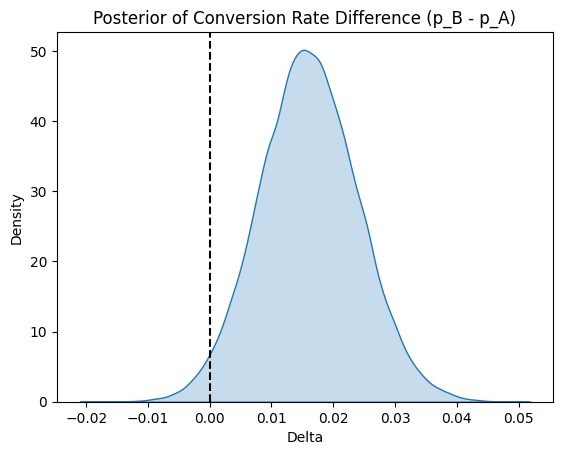

Probability that p_B > p_A: 0.978
Probability that p_B > p_A (another approach): 0.978


In [ ]:
signups_A = 28
clicks_A = 1055

signups_B = 45
clicks_B = 1057

# Prior parameters for Beta distribution: Beta(alpha, beta)
# Uniform prior: Beta(1, 1)
alpha_prior = (1, 1)
beta_prior = (1, 1)

# Posterior for A: Beta(alpha + successes, beta + failures)
posterior_A = np.random.beta(signups_A + alpha_prior[0],
                             clicks_A - signups_A + alpha_prior[1],
                             size=100_000)

posterior_B = np.random.beta(signups_B + beta_prior[0],
                             clicks_B - signups_B + beta_prior[1],
                             size=100_000)

delta = posterior_B - posterior_A

sns.kdeplot(delta, fill=True)
plt.axvline(0, color='black', linestyle='--')
plt.title("Posterior of Conversion Rate Difference (p_B - p_A)")
plt.xlabel("Delta")
plt.ylabel("Density")
plt.show()

prob_b_beats_a = np.mean(delta > 0)
prob_b_beats_a_1 = (posterior_B > posterior_A).mean()
print(f"Probability that p_B > p_A: {prob_b_beats_a:.3f}")
print(f"Probability that p_B > p_A (another approach): {prob_b_beats_a_1:.3f}")

Апріорний розподіл (prior distribution) - це наші припущення про параметр (наприклад, ймовірність конверсії p_A), до того, як ми побачили якісь дані.

Апостеріорний розподіл (posterior distribution) - це наші оновлені уявлення про параметр після того, як ми побачили реальні дані.

Результати Баєсовського підходу будуть схожі з Бутстрапом чи іншим частотним тестом (t-test, ztest), а у контексті множинної перевірки гіпотез всеодно варто використовувати коригування тесту:

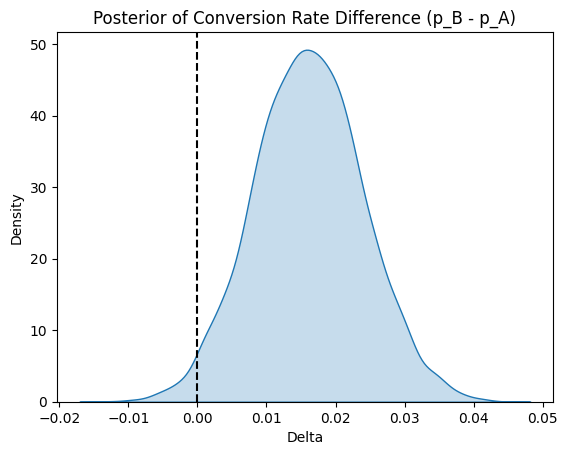

Probability that p_B > p_A: 0.978


In [ ]:
values_A = np.hstack(([0]*(1055-28),[1]*28))
values_B = np.hstack(([0]*(1057-45),[1]*45))

bootstrap_A = pd.Series([pd.Series(values_A).sample(len(values_A), replace=True).mean() for _ in range(10000)])
bootstrap_B = pd.Series([pd.Series(values_B).sample(len(values_B), replace=True).mean() for _ in range(10000)])

bootstrap_delta = bootstrap_B - bootstrap_A

sns.kdeplot(bootstrap_delta, fill=True)
plt.axvline(0, color='black', linestyle='--')
plt.title("Posterior of Conversion Rate Difference (p_B - p_A)")
plt.xlabel("Delta")
plt.ylabel("Density")
plt.show()

bootstrap_prob_b_beats_a = np.mean(bootstrap_delta > 0)
print(f"Probability that p_B > p_A: {bootstrap_prob_b_beats_a:.3f}")

Hierarchical Modeling ... coming soon/

# Bucketing
Для бутстрап-вибірок потрібно задавати розмір такий самий, як і в початковій вибірки: зміна статистики залежатиме від розміру вибірки. Якщо ми хочемо апроксимувати цю мінливість, нам потрібно використовувати повторні вибірки однакового розміру. Проте наприклад у нас 1 млн. спостережень, то подальші розразунки можуть бути дуже ресурсо затратними. Тут варто використовувати бакети на вхід бутстрапу. За такого підходу: зберігається умова про незалежність спостережень завдяки рівномірного розподілу за бакетами; зберігається інформація про метрику у вихідній вибірці за її меншого розміру.

In [ ]:
b_n = 5000
n = 100000

val_1 = np.random.exponential(scale=1/0.01, size=n)
val_2 = np.random.exponential(scale=1/0.011, size=n)

sample_exp = pd.DataFrame({
    "values": np.concatenate([val_1, val_2]),
    "variant": ["A" for _ in range(n)] + ["B" for _ in range(n)],
    "backet": [i for i in range(b_n)] * int(n*2/b_n)
})

In [ ]:
sample_exp.head()

,values,variant,backet
0,6.813004,A,0
1,123.832837,A,1
2,39.773857,A,2
3,166.390929,A,3
4,113.905984,A,4


In [ ]:
backeted_sample_exp = sample_exp.groupby(by=["backet", "variant"])["values"].agg(
    mu=np.mean,
    sd_mu=np.std
).reset_index()

/tmp/ipython-input-24-4046898857.py:1: FutureWarning: The provided callable <function mean at 0x7c32a32163e0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  backeted_sample_exp = sample_exp.groupby(by=["backet", "variant"])["values"].agg(
/tmp/ipython-input-24-4046898857.py:1: FutureWarning: The provided callable <function std at 0x7c32a3216520> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  backeted_sample_exp = sample_exp.groupby(by=["backet", "variant"])["values"].agg(


In [ ]:
# the same mean value in backeted data
round(np.mean(sample_exp['values']), 5) == round(np.mean(backeted_sample_exp['mu']), 5)

np.True_

In [ ]:
# nearly the same variance
print(np.var(sample_exp['values'] / len(sample_exp['values'])))
print(np.var(backeted_sample_exp['mu'] / len(backeted_sample_exp['mu'])))

2.3099202436197348e-07
4.777944154239197e-06


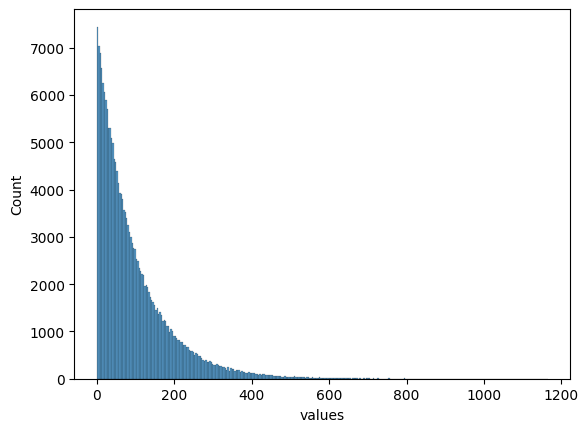

In [ ]:
sns.histplot(data=sample_exp, x='values')
plt.show()

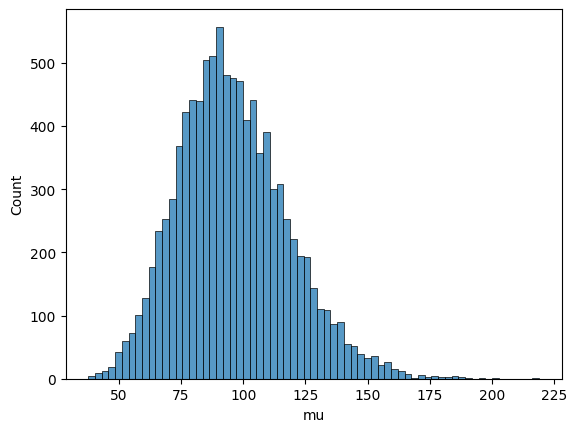

In [ ]:
sns.histplot(data=backeted_sample_exp, x='mu')
plt.show()

Based on bucketed_sample_exp, you can now construct the bootstrap distribution, its delta, and the confidence interval to make final decision about A/B test.

# Monte Carlo
The Monte Carlo approach is a rather powerful tool that allows us to verify whether a chosen criterion is valid in practice, or to understand which criterion is better suited for us.

## Monte Carlo Simulation with Artificial Data

### Example 1

In [ ]:
np.random.seed(42)

bad_cnt = 0
N = 10000
alpha = 0.05

sample_dist = stats.norm(loc=2, scale=3)
mu0 = sample_dist.expect()
for _ in range(N):
  # generate new random variate samples
  test = sample_dist.rvs(5)
  control = sample_dist.rvs(5)

  pvalue = ttest_ind(test, control, alternative='two-sided').pvalue
  bad_cnt += (pvalue < alpha)

print(f"FPR: {round(bad_cnt / N, 4)}")

FPR: 0.0519


In [ ]:
# let's see confidence intervals
proportion_confint(count=bad_cnt, nobs=N, alpha=0.05, method="wilson")

(0.04772180742973847, 0.05642233191006188)

From the Monte Carlo simulation, we determined that the t-test is suitable for small samples because our Type I error (alpha) falls within the confidence interval.

### Example 2

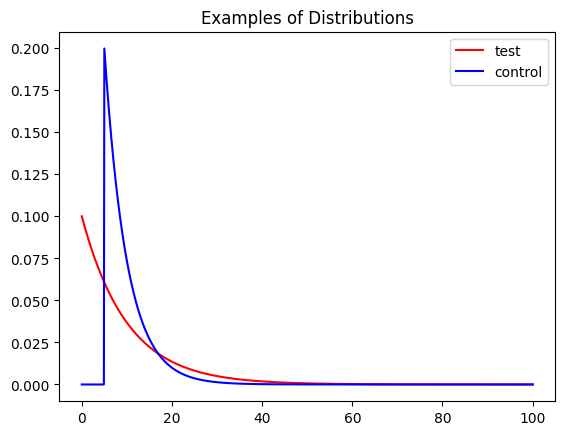

mean_t: 10.0, mean_c: 10.0


In [ ]:
# let's try with two different distribution with similar mean values
np.random.seed(42)

test_dist = stats.expon(scale=10)
control_dist = stats.expon(loc=5, scale=5)

x = np.linspace(0, 100, 1000)

plt.plot(x, test_dist.pdf(x), label='test', color='red')
plt.plot(x, control_dist.pdf(x), label='control', color='blue')
plt.title('Examples of Distributions')
plt.legend()
plt.show()

print(f"mean_t: {test_dist.mean()}, mean_c: {control_dist.mean()}")

In [35]:
def check_criterion(test_dist, control_dist, sample_size, N_exps=5000, is_print=True):
  np.random.seed(35)
  bad_cnt = 0
  alpha = 0.05

  for _ in tqdm(range(N_exps)):
    test = test_dist.rvs(sample_size)
    control = control_dist.rvs(sample_size)

    pvalue = ttest_ind(test, control, equal_var=False, alternative='two-sided').pvalue
    bad_cnt += (pvalue < alpha)

  if is_print:
    print(f"FPR: {round(bad_cnt / N_exps, 4)}")
    print(f"CI={proportion_confint(count=bad_cnt, nobs=N_exps, alpha=0.05, method='wilson')}")
  else:
    return proportion_confint(count=bad_cnt, nobs=N_exps, alpha=0.05, method='wilson')

In [ ]:
check_criterion(test_dist=test_dist, control_dist=control_dist, sample_size=10)

  0%|          | 0/5000 [00:00<?, ?it/s]

FPR: 0.0644
CI=(0.057925013077742796, 0.07154380885679097)


We observe that alpha is not within the confidence interval, indicating that the t-test is not appropriate for this small sample size in this case. But you can determine the optimal sample size using this Monte Carlo approach.

In [ ]:
alpha = 0.05
scale = np.arange(20, 110, 20)
for N in scale:
  left, right = check_criterion(test_dist, control_dist, N, is_print=False)
  if left < alpha < right:
    print(f"Min sample size: {N}")
    break

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Min sample size: 60


You can see that the t-test works effectively with sample sizes starting from 60

## Monte Carlo Simulation with Real Data
Let's assume we have income data. We want to determine if a t-test is an appropriate method for conducting an A/B test on this data, and then proceed to perform the A/B test itself.

In [4]:
!gdown --id 1zLKWeJ_OZjxuKlP561-GopniC0_Pt_X6
df = pd.read_csv('/content/age_children_income_1000.csv')
df.head()

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1zLKWeJ_OZjxuKlP561-GopniC0_Pt_X6
To: /content/age_children_income_1000.csv
100% 38.8k/38.8k [00:00<00:00, 45.2MB/s]


,age,number_of_children,income
0,42.772420,0,34396.537188
1,29.561090,0,183350.052521
2,54.380735,0,53689.856555
3,42.551689,0,109080.913926
4,38.713080,0,153612.343419


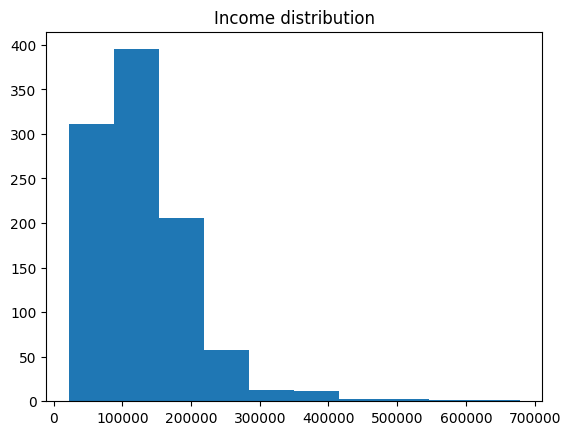

In [6]:
plt.hist(df['income'])
plt.title('Income distribution')
plt.show()

Let's determine the distribution of this data. The code below was found on the internet.

  1 / 110: ksone
  2 / 110: kstwo
  3 / 110: kstwobign
  4 / 110: norm
  5 / 110: alpha
  6 / 110: anglit
  7 / 110: arcsine
  8 / 110: beta
  9 / 110: betaprime
 10 / 110: bradford
 11 / 110: burr
 12 / 110: burr12
 13 / 110: fisk
 14 / 110: cauchy
 15 / 110: chi
 16 / 110: chi2
 17 / 110: cosine
 18 / 110: dgamma
 19 / 110: dpareto_lognorm
 20 / 110: dweibull
 21 / 110: expon
 22 / 110: exponnorm
 23 / 110: exponweib
 24 / 110: exponpow
 25 / 110: fatiguelife
 26 / 110: foldcauchy
 27 / 110: f
 28 / 110: foldnorm
 29 / 110: weibull_min
 30 / 110: truncweibull_min
 31 / 110: weibull_max
 32 / 110: genlogistic
 33 / 110: genpareto
 34 / 110: genexpon
 35 / 110: genextreme
 36 / 110: gamma
 37 / 110: erlang
 38 / 110: gengamma
 39 / 110: genhalflogistic
 40 / 110: genhyperbolic
 41 / 110: gompertz
 42 / 110: gumbel_r
 43 / 110: gumbel_l
 44 / 110: halfcauchy
 45 / 110: halflogistic
 46 / 110: halfnorm
 47 / 110: hypsecant
 48 / 110: gausshyper
 49 / 110: invgamma
 50 / 110: invgauss
 51

Text(0, 0.5, 'Frequency')

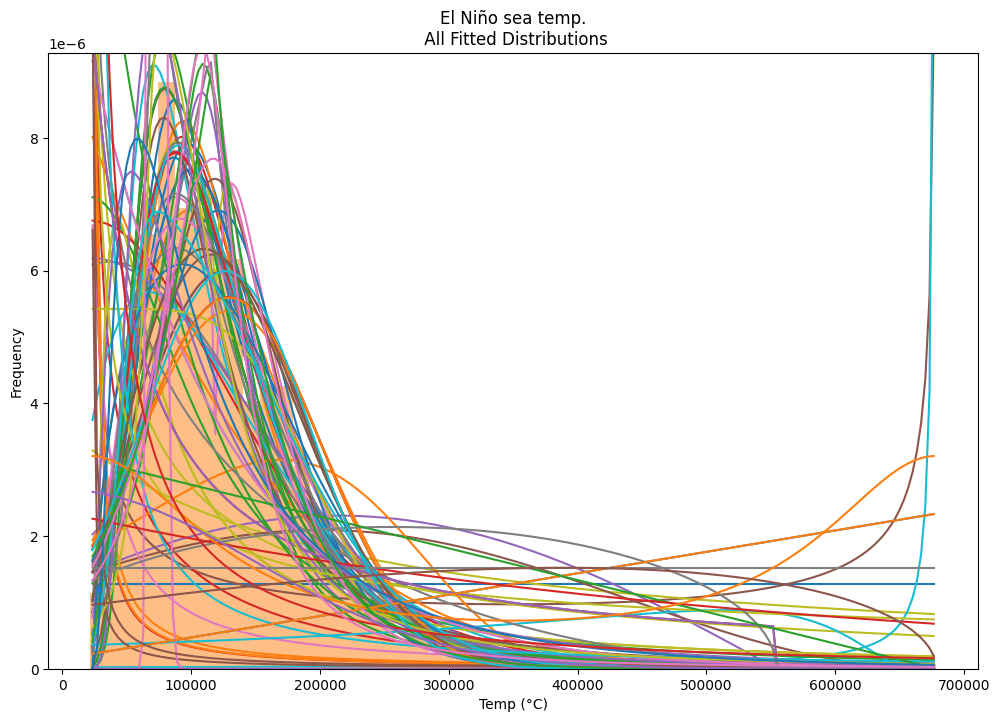

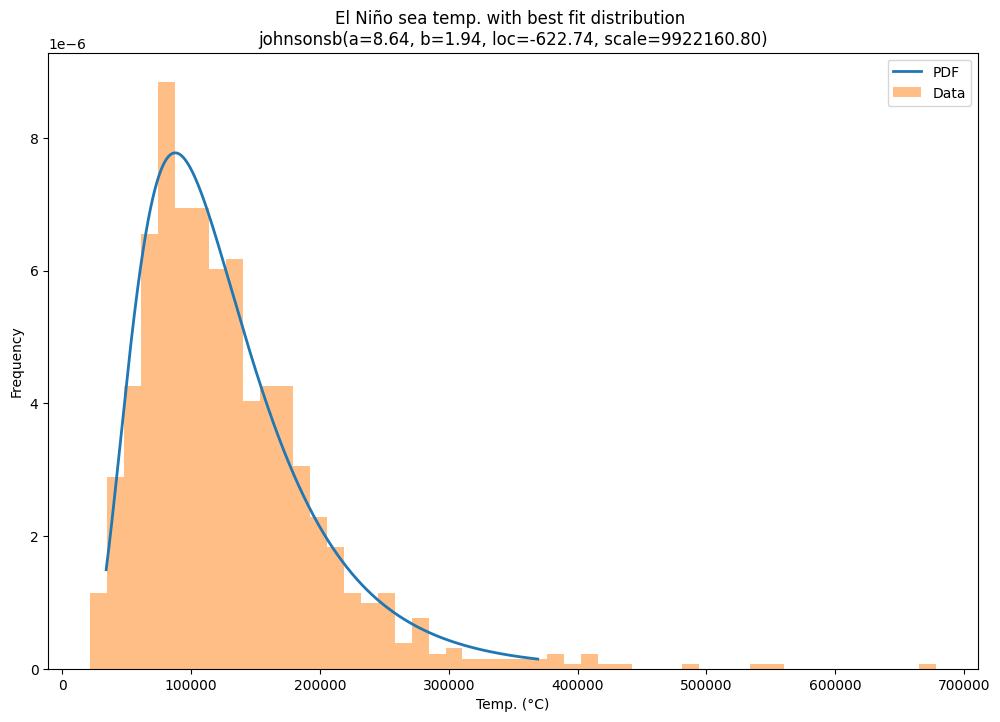

In [10]:
import warnings
import scipy.stats as st
import statsmodels.api as sm
from scipy.stats._continuous_distns import _distn_names
import matplotlib
import matplotlib.pyplot as plt

# matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
# matplotlib.style.use('ggplot')

# Create models from data
def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Best holders
    best_distributions = []

    # Estimate distribution parameters from data
    for ii, distribution in enumerate([d for d in _distn_names if not d in ['levy_stable', 'studentized_range']]):

        print("{:>3} / {:<3}: {}".format( ii+1, len(_distn_names), distribution ))

        distribution = getattr(st, distribution)

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                best_distributions.append((distribution, params, sse))

        except Exception:
            pass


    return sorted(best_distributions, key=lambda x:x[2])

def make_pdf(dist, params, size=10000):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

# Load data from statsmodels datasets
data = df['income']

# Plot for comparison
plt.figure(figsize=(12,8))
ax = data.plot(kind='hist', bins=50, density=True, alpha=0.5, color=list(matplotlib.rcParams['axes.prop_cycle'])[1]['color'])

# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
best_distibutions = best_fit_distribution(data, 200, ax)
best_dist = best_distibutions[0]

# Update plots
ax.set_ylim(dataYLim)
ax.set_title(u'El Niño sea temp.\n All Fitted Distributions')
ax.set_xlabel(u'Temp (°C)')
ax.set_ylabel('Frequency')

# Make PDF with best params
pdf = make_pdf(best_dist[0], best_dist[1])

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=50, density=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist[0].shapes + ', loc, scale').split(', ') if best_dist[0].shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_dist[1])])
dist_str = '{}({})'.format(best_dist[0].name, param_str)

ax.set_title(u'El Niño sea temp. with best fit distribution \n' + dist_str)
ax.set_xlabel(u'Temp. (°C)')
ax.set_ylabel('Frequency')

In [11]:
dist_df = pd.DataFrame(best_distibutions).sort_values(2)
dist_df.head()

,0,1,2
0,<scipy.stats._continuous_distns.johnsonsb_gen ...,"(8.635547387774977, 1.940117105713055, -622.73...",1.079567e-10
1,<scipy.stats._continuous_distns.norminvgauss_g...,"(29.067271580227185, 28.826575678471475, -3576...",1.079802e-10
2,<scipy.stats._continuous_distns.lognorm_gen ob...,"(0.5025175713532029, -1861.8778563039434, 1156...",1.079923e-10
3,<scipy.stats._continuous_distns.johnsonsu_gen ...,"(-6.473814796203333, 1.9820095590762135, -996....",1.080549e-10
4,<scipy.stats._continuous_distns.moyal_gen obje...,"(89998.53204903823, 30662.92827229847)",1.087651e-10


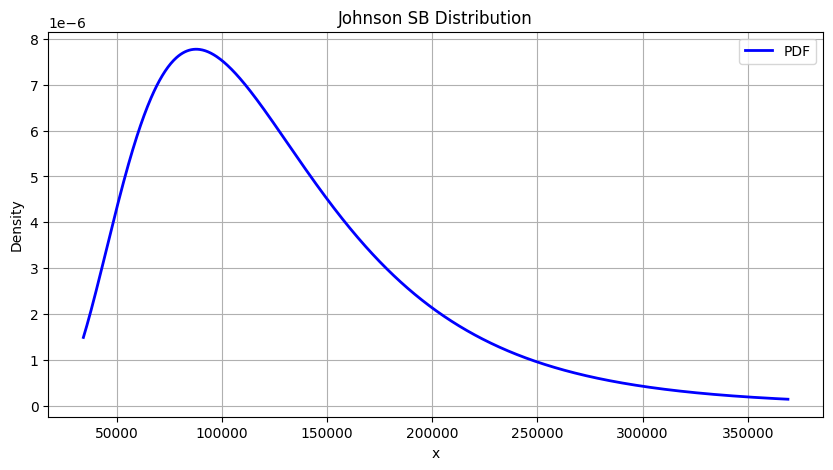

In [33]:
# let's create distribution with defined parametrs
dist = johnsonsb(
    dist_df.iloc[0, 1][0],
    dist_df.iloc[0, 1][1],
    loc=dist_df.iloc[0, 1][2],
    scale=dist_df.iloc[0, 1][3]
    )
x = np.linspace(dist.ppf(0.01), dist.ppf(0.99), 1000)

plt.figure(figsize=(10, 5))
plt.plot(x, dist.pdf(x), 'b-', lw=2, label='PDF')
plt.title('Johnson SB Distribution')
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

In [28]:
np.random.seed(42)

bad_cnt = 0
N = 5000
alpha = 0.05

for _ in tqdm(range(N)):
  # generate new random variate samples
  test = dist.rvs(1000)
  control = dist.rvs(1000)

  pvalue = ttest_ind(test, control, alternative='two-sided').pvalue
  bad_cnt += (pvalue < alpha)

print(f"FPR: {round(bad_cnt / N, 4)}")

  0%|          | 0/5000 [00:00<?, ?it/s]

FPR: 0.0466


We can observe that the t-test performs effectively with this data. You can also store all p-values in a list and then create a Q-Q plot for a uniform distribution.

In [39]:
# let's try compare original data with shifted one

original_mean = dist.mean()
print("Original mean:", original_mean)

# Desired shift
shift = 5000
new_loc = dist_df.iloc[0, 1][2] + shift

shifted_dist = johnsonsb(dist_df.iloc[0, 1][0], dist_df.iloc[0, 1][1], loc=new_loc, scale=dist_df.iloc[0, 1][3])

new_mean = shifted_dist.mean()
print("New mean:", new_mean)
print("Delta mean:", new_mean - original_mean)

Original mean: 129330.60489052547
New mean: 134330.60489052546
Delta mean: 4999.999999999985


In [41]:
check_criterion(dist, shifted_dist, 1000, is_print=False)

  0%|          | 0/5000 [00:00<?, ?it/s]

(0.3481951569547781, 0.3748176500243918)

From here, we derive confidence intervals for the Power of the A/B test. You can increase this observed power (which lies within this confidence interval) by increasing the effect size or the number of samples.

DONE!